# Example #2: Simulating an SIS mixer

- This example will simulate a simple SIS mixer.
- The input will consists of 3 signals:
    - a strong local-osciallator (LO) signal at 230 GHz,
    - a weak RF signal at 232 GHz, and
    - an IF output at 2 GHz.
- An arbitrary embedding circuit is included (therefore, harmonic balance is required).
- The response function is generated from an experimental DC I-V curve.
- This simulation will calculate:
    - the pumped I-V curve, and
    - the mixer's gain.

In [5]:
%matplotlib inline

import qmix
import numpy as np
import scipy.constants as sc 
import matplotlib.pyplot as plt

from qmix.mathfn.misc import slope
from qmix.qtcurrent import qtcurrent
from qmix.circuit import EmbeddingCircuit
from qmix.harmonic_balance import harmonic_balance

# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

## Define the junction properties
- These are common parameters that describe the electrical properties of SIS junctions. QMix only uses normalized values, so these values will be used to de-normalize whatever voltages, currents and frequencies that QMix calculates.

In [6]:
vgap = 2.7e-3              # gap voltage in [V]
rn   = 13.5                # normal resistance in [ohms]
igap = vgap / rn           # gap current in [A]
fgap = sc.e * vgap / sc.h  # gap frequency in [Hz]

## Define the embedding circuit
- We will load the ``EmbeddingCircuit`` class with all of the information about the embedding circuit. This includes the Thevenin voltage, the Thevenin impedance, and the frequency of each signal that is applied to the junction.
- Note: 
   - All of the circuit properties are normalized: 
      - voltages are normalized to the gap voltage (``vgap``), 
      - resistances to the normal resistance (``rn``), 
      - currents to the gap current (``igap = vgap / rn``), and 
      - frequencies to the gap frequency (``fgap``).
   - This example includes the embedding circuit. Each tone/harmonic requires:
      - the Thevenin voltage (normalized to ``vgap``)
      - the Thevenin impedance (normalized to ``rn``)
      - the frequency (normalized to ``fgap``).
   - The normalized frequency is the same thing as the normalized photon voltage.

In [7]:
# simulation parameters
num_f = 3  # number of tones
num_p = 1  # number of harmonics
num_b = (10, 5, 10)  # Bessel function summation limits

# LO signal
f_lo         = 230e9 / fgap      # frequency (normalized value)
alpha_lo     = 1.2               # junction drive level (normalized value)
impedance_lo = 0.3 - 0.3*1j      # embedding impedance (normalized value)

# RF signal
f_rf         = 232e9 / fgap      # frequency (normalized value)
alpha_rf     = 0.012             # junction drive level (normalized value)
impedance_rf = 0.3 - 0.3*1j      # embedding impedance (normalized value)

# IF signal
f_if         = 2e9 / fgap        # frequency (normalized value)
impedance_if = 1.                # embedding impedance (normalized value)

# build embedding circuit
cct = EmbeddingCircuit(num_f, num_p, fgap=fgap, vgap=vgap, rn=rn)
cct.comment[1][1] = 'LO'
cct.comment[2][1] = 'USB'
cct.comment[3][1] = 'IF'

# photon voltages (same as normalized frequency)
cct.freq[1] = f_lo
cct.freq[2] = f_rf
cct.freq[3] = f_if

# Thevenin voltages
cct.vt[1, 1] = cct.freq[1] * alpha_lo
cct.vt[2, 1] = cct.freq[2] * alpha_rf
cct.vt[3, 1] = 0.

# Thevenin impedances
cct.zt[1, 1] = impedance_lo
cct.zt[2, 1] = impedance_rf
cct.zt[3, 1] = impedance_if

cct.print_info()

Embedding circuit (Tones:3, Harmonics:1)
   f=1, p=1			230.0 GHz x 1		LO
	Thev. voltage:		0.4228 * Vgap
	              		1.2000 * Vph
	Thev. impedance:	0.30-0.30j * Rn
	Avail. power:   	4.02E-08 W
	                	-43.956 dBm
   f=2, p=1			232.0 GHz x 1		USB
	Thev. voltage:		0.0043 * Vgap
	              		0.0120 * Vph
	Thev. impedance:	0.30-0.30j * Rn
	Avail. power:   	4.09E-12 W
	                	-83.881 dBm
   f=3, p=1			2.0 GHz x 1		IF
	Thev. voltage:		0.0000 * Vgap
	              		0.0000 * Vph
	Thev. impedance:	1.00+0.00j * Rn
	Avail. power:   	0.00E+00 W
	                	-inf dBm



## Generate the response function

- Here, the response function is generated from an experimental DC I-V curve.

In [8]:
# Load DC I-V data
dciv_exp_data = np.genfromtxt('example-data/dciv.csv', delimiter=',')
dciv = qmix.exp.DCData(dciv_exp_data)

# Grab response function
resp = dciv.resp


DC I-V data: 

	Vgap:  		  2.72	mV
	fgap:  		656.99	GHz

	Rn:    		 14.22	ohms
	Rsg:   		367.87	ohms
	Q:     		 25.87

	Jc:    		 12.74	kA/cm^2
	Ileak: 		  8.68	uA

	Offset:		  0.10	mV
	       		  9.71	uA

	Vint:  		  0.21	mV



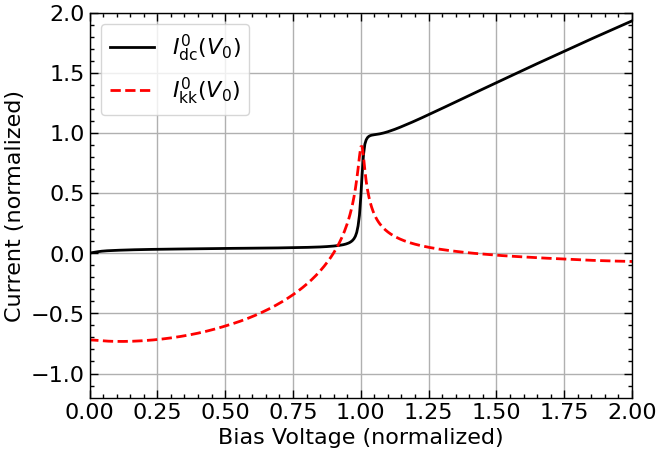

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(7,5))
resp.plot(ax=ax);

## Perform harmonic balance

- Calculate the voltage drop across the junction for each tone/harmonic using harmonic balance.

In [10]:
vj = harmonic_balance(cct, resp, num_b)

Running harmonic balance:
 - 3 tone(s) and 1 harmonic(s)
 - 7 calls to the quasiparticle tunneling current (qtc) function per iteration
 - max. iterations: 10
Estimated time:
 - time per qtc call:     0.05 s /   0.00 min /  0.00 hrs
 - time per iteration:    0.33 s /   0.01 min /  0.00 hrs
 - max sim time:          3.26 s /   0.05 min /  0.00 hrs
Error after 0 iteration(s):
	f:1, p:1,   med. rel. error:     0.265,   max. rel. error:     1.069,     0.0 % complete
	f:2, p:1,   med. rel. error:     0.202,   max. rel. error:     0.811,     0.0 % complete
	f:3, p:1,   med. rel. error: 99999.999,   max. rel. error: 99999.999,     0.0 % complete
Calculating inverse Jacobian |--------------------| 100.0% Complete
Applying correction
Error after 1 iteration(s):
	f:1, p:1,   med. rel. error:     0.003,   max. rel. error:     0.156,    33.8 % complete
	f:2, p:1,   med. rel. error:     0.014,   max. rel. error:     0.270,    14.9 % complete
	f:3, p:1,   med. rel. error:     0.074,   max. rel. erro

## Calculate tunnelling currents
- ``idc`` is the DC tunneling current
- ``ilo`` is the AC tunneling current at the LO frequency
- ``iif`` is the AC tunneling current at the IF frequency

In [11]:
freq_list = [0., f_lo, f_if]
idc, ilo, iif = qtcurrent(vj, cct, resp, freq_list, num_b=num_b)

Calculating tunneling current...
 - 3 tone(s)
 - 1 harmonic(s)
Done.
Time: 0.1666 s



### Calculate mixer gain

In [12]:
# Available power from upper sideband (USB)
pusb = cct.available_power(f=2)

# Power delivered to load
rload = cct.zt[3,1].real * rn
pload = 0.5 * np.abs(iif * igap)**2 * rload

# Gain
gain = pload / pusb

## Plot Results

In [13]:
# Conversion: normalized -> de-normalized
vmv = vgap / sc.milli 
iua = igap / sc.micro

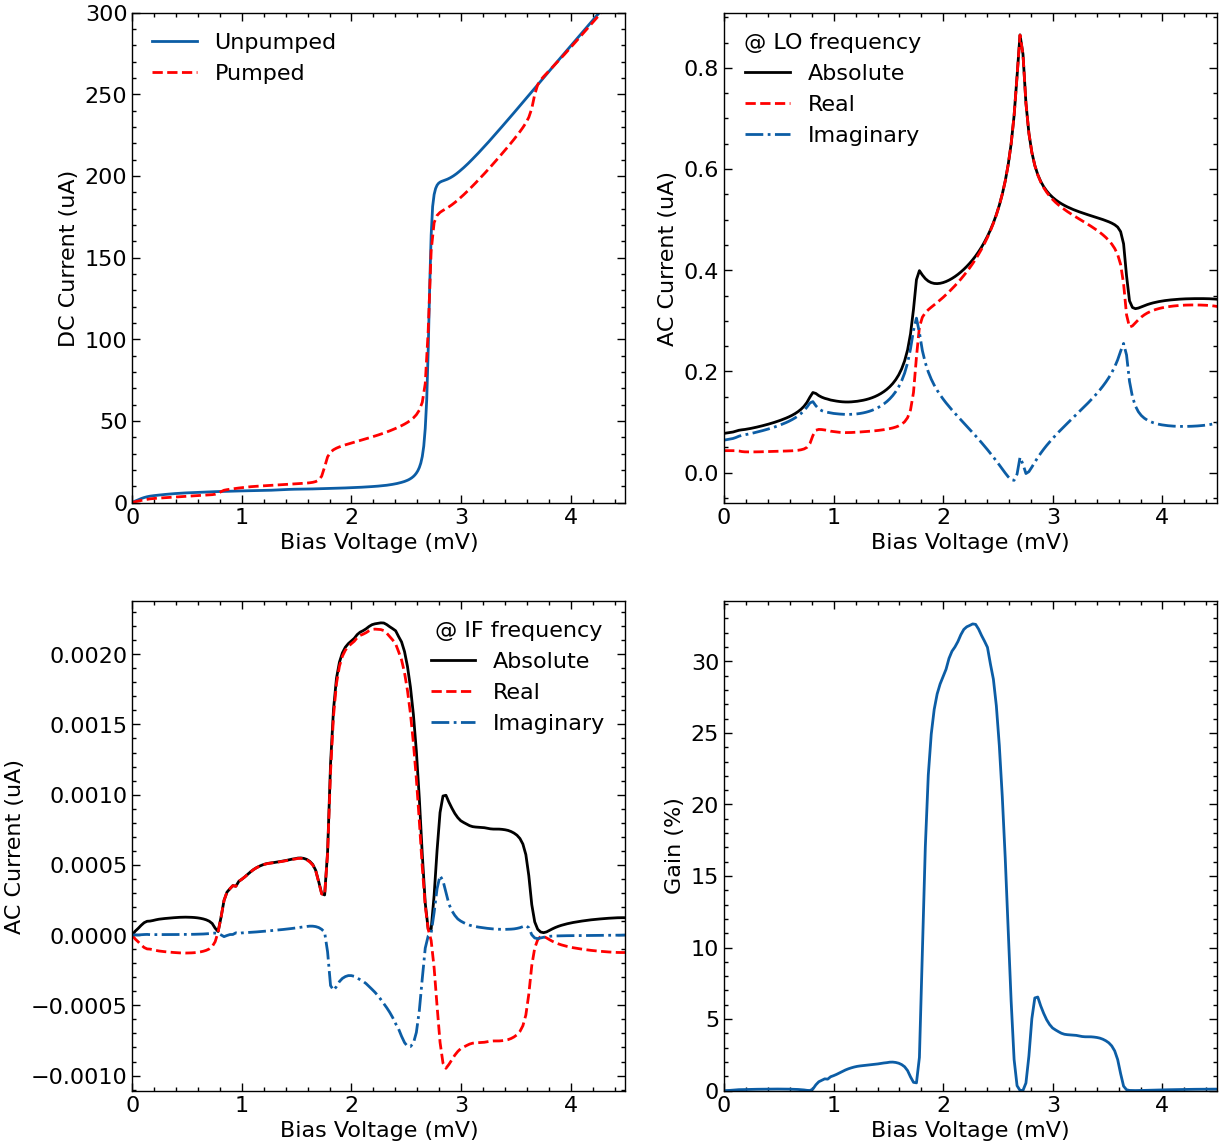

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,14))

# Plot I-V curves
ax1.plot(resp.voltage*vmv, resp.current*iua, label='Unpumped')
ax1.plot(cct.vb*vmv, idc.real*iua, 'r--', label='Pumped')
ax1.set(xlim=(0,4.5), xlabel='Bias Voltage (mV)')
ax1.set(ylim=(0,300), ylabel='DC Current (uA)')
ax1.legend(frameon=False)

# Plot AC currents at LO frequency
ax2.plot(cct.vb*vmv, np.abs(ilo), 'k', label='Absolute')
ax2.plot(cct.vb*vmv, ilo.real, 'r--', label='Real')
ax2.plot(cct.vb*vmv, ilo.imag, ls='-.', label='Imaginary')
ax2.set(xlim=(0,4.5), xlabel='Bias Voltage (mV)')
ax2.set(ylabel='AC Current (uA)')
ax2.legend(frameon=False, loc=2, title="@ LO frequency")

# Plot AC currents at IF frequency
ax3.plot(cct.vb*vmv, np.abs(iif), 'k', label='Absolute')
ax3.plot(cct.vb*vmv, iif.real, 'r--', label='Real')
ax3.plot(cct.vb*vmv, iif.imag, ls='-.', label='Imaginary')
ax3.set(xlim=(0,4.5), xlabel='Bias Voltage (mV)')
ax3.set(ylabel='AC Current (uA)')
ax3.legend(frameon=False, loc=1, title="@ IF frequency")

# Plot gain of SIS junction
ax4.plot(cct.vb*vmv, gain*100)
ax4.set(xlim=(0,4.5), xlabel='Bias Voltage (mV)')
ax4.set(ylabel='Gain (%)')
ax4.set_ylim(bottom=0)

fig.savefig('multi-tone-results.png', dpi=500, bbox_inches='tight');